In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [6]:
class conv_block(nn.Module):
  def __init__(self, in_channels, out_channels,**kwrags):
    super(conv_block,self).__init__()
    self.relu = nn.ReLU()
    self.conv = nn.Conv2d(in_channels,out_channels,**kwrags)
    self.batchnorm = nn.BatchNorm2d(out_channels)

  def forward(self, x):
    return self.relu(self.batchnorm(self.conv(x)))

In [7]:
class Stem(nn.Module):
 
   def __init__(self,in_channels=3):
    super(Stem,self).__init__()

    self.conv1 = conv_block(3,32,kernel_size=3,stride=2,padding=0)
    self.conv2 = conv_block(32,32,kernel_size=3,stride=1,padding=0)
    self.conv3 = conv_block(32,64,kernel_size=3,stride=1,padding=1)

    self.maxpool4 = nn.MaxPool2d(kernel_size=3,stride=2)
    self.conv4 = conv_block(64,96,kernel_size=3,stride=2)

    self.branche1 = nn.Sequential(
        conv_block(160,64,kernel_size=1,stride=1),
        conv_block(64,96,kernel_size=3,stride=1,padding=0)
    )

    self.branche2 = nn.Sequential(
        conv_block(160,64,kernel_size=1,stride=1),
        conv_block(64,64,kernel_size=(7,1),stride=1,padding=(3,0)),
        conv_block(64,64,kernel_size=(1,7),stride=1,padding=(0,3)),
        conv_block(64,96,kernel_size=3,stride=1,padding=0)
    )

    self.pool5 = nn.MaxPool2d(kernel_size=3,stride=2,padding=0)
    self.conv5 = conv_block(192,192,kernel_size=3,stride=2,padding=0)
  
  def forward(self,x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x1 = self.maxpool4(x)
    x2 = self.conv4(x)

    x = torch.cat([x1,x2],1)
    x1 = self.branche1(x)
    x2 = self.branche2(x)
    x = torch.cat([x1,x2],1)

    x1= self.pool5(x)
    x2 = self.conv5(x)

    return torch.cat([x1,x2],1)



In [8]:
x = torch.rand((1,3,299,299))
model_stem = Stem()
y= model_stem(x)
print(y.shape)

torch.Size([1, 384, 35, 35])


In [9]:
class InceptionA(nn.Module):
  def __init__(self,in_channels):

    super(InceptionA,self).__init__()
    self.branche1 = conv_block(in_channels,32,kernel_size=1,stride=1)

    self.branche2 = nn.Sequential(
        conv_block(in_channels,32,kernel_size=1,stride=1),
        conv_block(32,32,kernel_size=3,stride=1,padding=1)
    )

    self.branche3 = nn.Sequential(
        conv_block(in_channels,32,kernel_size=1,stride=1),
        conv_block(32,48,kernel_size=3,stride=1,padding=1),
        conv_block(48,64,kernel_size=3,stride=1,padding=1)
    )

    self.conv_linear = nn.Conv2d(128,384,kernel_size=1)


  def forward(self,x):
    x  = F.relu(x)
    x1 = self.branche1(x)
    x2 = self.branche2(x)
    x3 = self.branche3(x)

    y = torch.cat([x1,x2,x3],1)
    y = self.conv_linear(y)

    z = x.add(y)

    return z


In [10]:
xx = torch.rand((1,384,35,35))
model = InceptionA(384)
yy= model(xx)
print(yy.shape)

torch.Size([1, 384, 35, 35])


In [11]:
class InceptionA_red(nn.Module):
  def __init__(self,in_channels):
    super(InceptionA_red,self).__init__()
    self.pool = nn.MaxPool2d(kernel_size=3,stride=2)
    self.conv = conv_block(in_channels,384,kernel_size=3,stride=2,padding=0)
    self.branche = nn.Sequential(
        conv_block(in_channels,256,kernel_size=1,padding=0),
        conv_block(256,256,kernel_size=3,stride=1,padding=1),
        conv_block(256,384,kernel_size=3,stride=2,padding=0)
    )


  def forward(self,x):
    x1 = self.pool(x)
    x2 = self.conv(x)
    x3 = self.branche(x)

    return torch.cat([x1,x2,x3],1)


In [12]:
xx = torch.rand((1,384,35,35))
model = InceptionA_red(384)
yy= model(xx)
print(yy.shape)

torch.Size([1, 1152, 17, 17])


In [13]:
class InceptionB(nn.Module):
  def __init__(self,in_channels):
    super(InceptionB,self).__init__()

    self.conv1x1 = conv_block(in_channels,192,kernel_size=1,stride=1)
    
    self.branche = nn.Sequential(
        conv_block(in_channels,128,kernel_size=1,stride=1),
        conv_block(128,160,kernel_size=(1,7),stride=1,padding=(0,3)),
        conv_block(160,192,kernel_size=(7,1),stride=1,padding=(3,0))
    )

    self.conv_linear = nn.Conv2d(384,in_channels,kernel_size=1,stride=1)

  def forward(self,x):
    x = F.relu(x)

    x1 = self.conv1x1(x)
    x2 = self.branche(x)

    y = torch.cat([x1,x2],1)
    y = self.conv_linear(y)

    return x.add(y)


In [14]:
xx = torch.rand((1,1152,17,17))
model = InceptionB(1152)
yy= model(xx)
print(yy.shape)

torch.Size([1, 1152, 17, 17])


In [15]:
class InceptionB_red(nn.Module):
  def __init__(self,in_channels):
    super(InceptionB_red,self).__init__()

    self.maxpool = nn.MaxPool2d(kernel_size=3,stride=2)
    self.branche1= nn.Sequential(
        conv_block(in_channels,256,kernel_size=1,stride=1),
        conv_block(256,384,kernel_size=3,stride=2,padding=0)
    )

    self.branche2= nn.Sequential(
        conv_block(in_channels,256,kernel_size=1,stride=1),
        conv_block(256,288,kernel_size=3,stride=2,padding=0)
    )

    self.branche3 = nn.Sequential(
        conv_block(in_channels,256,kernel_size=1,stride=1),
        conv_block(256,288,kernel_size=3,stride=1,padding=1),
        conv_block(288,320,kernel_size=3,stride=2,padding=0)

    )

  def forward(self,x):
    x1 = self.maxpool(x)
    x2 = self.branche1(x)
    x3 = self.branche2(x)
    x4 = self.branche3(x)

    return torch.cat([x1,x2,x3,x4],1)
    

In [16]:
xx = torch.rand((1,1152,17,17))
model = InceptionB_red(1152)
yy= model(xx)
print(yy.shape)

torch.Size([1, 2144, 8, 8])


In [17]:
class InceptionC(nn.Module):
  def __init__(self,in_channels):
    super(InceptionC,self).__init__()

    self.conv1x1 = conv_block(in_channels,192,kernel_size=1,stride=1)
    self.branche = nn.Sequential(
        conv_block(in_channels,192,kernel_size=1,stride=1),
        conv_block(192,224,kernel_size=(1,3),stride=1,padding=(0,1)),
        conv_block(224,256,kernel_size=(3,1),stride=1,padding=(1,0))
    )

    self.conv_linear = nn.Conv2d(448,in_channels,kernel_size=1,stride=1)

  def forward(self,x):
    x = F.relu(x)

    x1 = self.conv1x1(x)
    x2 = self.branche(x)

    y = torch.cat([x1,x2],1)
    y = self.conv_linear(y)

    return x.add(y)





In [18]:
xx = torch.rand((1,2144,8,8))
model = InceptionC(2144)
yy= model(xx)
print(yy.shape)

torch.Size([1, 2144, 8, 8])


In [19]:
class Inception_ResnetV2(nn.Module):
  def __init__(self,in_channels=3,num_classes=10):
    super(Inception_ResnetV2,self).__init__()

    self.stem = Stem(in_channels=in_channels)

    l= []
    for i in range(5):
      l.append(InceptionA(384))
    
    self.A_block = nn.Sequential(*l)

    self.A_red = InceptionA_red(384)

    l= []
    for i in range(10):
      l.append(InceptionB(1152))

    self.B_block = nn.Sequential(*l)

    self.B_red= InceptionB_red(1152)

    l= []
    for i in range(5):
      l.append(InceptionC(2144))

    self.C_block = nn.Sequential(*l)

    self.avg_pool = nn.AdaptiveAvgPool2d((1,1))


    self.dropout = nn.Dropout(p=0.2)

    self.fc = nn.Linear(2144,num_classes)
  
  def forward(self,x):
    x = self.stem(x)

    x = self.A_block(x)
    x = F.relu(x)
    x = self.A_red(x)

    x = self.B_block(x)
    x = F.relu(x)
    x = self.B_red(x)
    
    x = self.C_block(x)
    x = self.avg_pool(x)

    x = torch.flatten(x,1)
    x = self.fc(x)

    x = self.dropout(x)

    return x


In [20]:
xx = torch.rand((1,3,299,299))
model = Inception_ResnetV2(in_channels=3,num_classes=10)
yy= model(xx)
print(yy.shape)

torch.Size([1, 10])


In [21]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hamzaraouzi","key":"28388e813c3436f16140fd50d764a55c"}'}

In [22]:
!mkdir -p ~/.kaggle
!cp  kaggle.json  ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [23]:
!kaggle datasets download -d prasunroy/natural-images

 98% 334M/342M [00:04<00:00, 81.9MB/s]
100% 342M/342M [00:04<00:00, 81.1MB/s]


In [24]:
from zipfile import ZipFile
file_name="natural-images.zip"
with ZipFile(file_name,"r") as zip :
  zip.extractall()
  print('Done')

Done


In [25]:
# organize dataset into a useful structure
from os import makedirs
from os import listdir
from shutil import copyfile
from random import seed
from random import random
# create directories
dataset_home = 'natural-images/'
subdirs = ['train/', 'test/']
for subdir in subdirs:
	# create label subdirectories
	labeldirs = ['airplane/', 'car/', 'cat/', 'dog/', 'flower/','fruit/','motorbike/',
              'person/']
	for labldir in labeldirs:
		newdir = dataset_home + subdir + labldir
		makedirs(newdir, exist_ok=True)

In [26]:
# seed random number generator
seed(1)
# define ratio of pictures to use for validation
val_ratio = 0.25
# copy training dataset images into subdirectories


for dir in listdir('natural_images/'):

  for file in listdir('natural_images/'+dir):
    src = 'natural_images/' +dir +'/' +file
    if random() < val_ratio:
      dest = 'natural-images/test/'+ dir +'/'+file
    else:
      dest = 'natural-images/train/'+ dir +'/'+file 

    copyfile(src,dest)

In [27]:
from torchvision import datasets, transforms
#Applying Transformation
train_transforms = transforms.Compose([
                                transforms.Resize((299,299)),
                                transforms.RandomRotation(30),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor()])

test_transforms = transforms.Compose([
                                      transforms.Resize((299,299)),
                                      transforms.ToTensor()])
train_data = datasets.ImageFolder(dataset_home  + '/train',  
                                    transform=train_transforms)                                       
test_data = datasets.ImageFolder(dataset_home + '/test', 
                                    transform=test_transforms)

#Data Loading
trainloader = torch.utils.data.DataLoader(train_data,shuffle=True,batch_size=48)
testloader = torch.utils.data.DataLoader(test_data,shuffle=True ,batch_size=48)

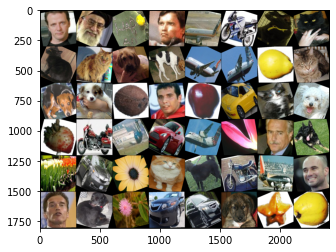

In [28]:
import torchvision
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
  
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

In [29]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [30]:
accuracy_list = []

def train(epoch,model):
    model.train()
    for batch_idx, (data, target) in enumerate(trainloader):
        # send to device
        data, target = data.to(device), target.to(device)


        optimizer.zero_grad()
        output = model(data)
        
        loss = nn.CrossEntropyLoss()(output, target)
        loss.backward()
        optimizer.step()
       
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(trainloader.dataset),
                100. * batch_idx / len(trainloader), loss.item()))


In [31]:
def test(model):
    model.eval()
    test_loss = 0
    correct = 0
   
    with torch.no_grad():
        for data, target in testloader:

            data, target = data.to(device), target.to(device)

            output = model(data)
            #sum up batch loss 
            loss = nn.CrossEntropyLoss()(output, target)
            test_loss += loss.item()
            _, predicted = output.max(1)

            correct += predicted.eq(target).sum().item()
        
        
        test_loss /= len(testloader.dataset)
        accuracy = 100.*correct/len(testloader.dataset)
        accuracy_list.append(accuracy)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct,len(testloader.dataset),
            accuracy
        ))

    return accuracy,test_loss

In [ ]:
model.to(device)

PATH ='model.pt'

decayRate = 0.94
optimizer = optim.RMSprop(model.parameters(),lr=0.045,eps=1.0,alpha=0.9,
                          )

lr_scheduler =optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate)


prev_test_accuracy =-1
for epoch in range(1,35):
  
    model.aux_logits = True
    train(epoch,model)
    model.aux_logits = False
    test_accuracy,test_loss = test(model)

    if epoch%2 == 0: lr_scheduler.step()

    if test_accuracy >prev_test_accuracy:
        torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': test_loss,
                }, PATH)
        print("weights from epoch {} has been saved ".format(epoch))
        prev_test_accuracy = test_accuracy

In [35]:
loaded_model = Inception_ResnetV2(in_channels=3,num_classes=10)

optimizer = optim.RMSprop(model.parameters(),lr=0.045,eps=1.0,alpha=0.9,
                          )
decayRate = 0.94
lr_scheduler =optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate)


checkpoint = torch.load(PATH)
loaded_model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

loaded_model.to(device)
loaded_model.eval()
loaded_model.aux_logits= False
test_accuracy,test_loss= test(loaded_model)


Test set: Average loss: 0.0026, Accuracy: 1666/1731 (96%)

